In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
import io

from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   prop = pd.read_excel(io.BytesIO(file_content))

print(prop.shape)

Saving 1. Proposals.xlsx to 1. Proposals (2).xlsx
(3361, 20)


# **Data Import & Basic Formatting**

In [75]:
# Set index to column NO.
prop.set_index('NO.', drop = True, inplace = True)
print(prop.shape)
print(prop.head())

(3361, 19)
    PROPOSAL NUMBER  CLIENT  \
NO.                           
1           Q191859  TS1577   
2           Q202049  PC0003   
3           Q201827  MT1388   
4           Q200480  TC1885   
5           Q200559  TS2190   

                                   SITE ADDRESS & CITY SCOPE OF WORK  \
NO.                                                                    
1               5229 Dundas Street West, Etobicoke, ON    Update RFS   
2                         7440 Goreway Dr, Mississauga   Class 2 RFS   
3                     383 Adelaide Street, Toronto, ON    Update RFS   
4                      300 New Toronto Street, Toronto   Class 3 RFS   
5    190 Borough Drive & 25 Town Centre Court, Toronto   Class 2 RFS   

    RFP NUMBER           YEAR INCORPORATED NO. UNITS NO. STOREYS  \
NO.                                                                
1          NaN                         NaN       NaN         NaN   
2          NaN                        1970        39          

In [76]:
#Drop columns with client identifying information (CLIENT WILL BE DROPPED AFTER WE TAKE WHAT WE NEED FROM IT)
prop = prop.drop(['SITE ADDRESS & CITY'], axis = 'columns')
print(prop.shape)

(3361, 18)


In [77]:
#See description of column types
prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3361 entries, 1 to 3361
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PROPOSAL NUMBER          3332 non-null   object        
 1   CLIENT                   3357 non-null   object        
 2   SCOPE OF WORK            3352 non-null   object        
 3   RFP NUMBER               127 non-null    object        
 4   YEAR INCORPORATED        3048 non-null   object        
 5   NO. UNITS                3091 non-null   object        
 6   NO. STOREYS              3012 non-null   object        
 7   NO. TOWNHOUSE BLOCKS     2926 non-null   object        
 8   PARKING GARAGE (LEVELS)  2946 non-null   object        
 9   COMPLETED PREVIOUS RFS   3344 non-null   object        
 10  REMINDER                 3351 non-null   object        
 11  FEE Breakdown            3249 non-null   object        
 12  Probable Fee             3230 non-null 

In [78]:
# Convert YEAR INCORPORATED to pd.datetime
prop['YEAR INCORPORATED'] = pd.to_datetime(prop['YEAR INCORPORATED'], errors = 'coerce')
print(prop.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3361 entries, 1 to 3361
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PROPOSAL NUMBER          3332 non-null   object        
 1   CLIENT                   3357 non-null   object        
 2   SCOPE OF WORK            3352 non-null   object        
 3   RFP NUMBER               127 non-null    object        
 4   YEAR INCORPORATED        1758 non-null   datetime64[ns]
 5   NO. UNITS                3091 non-null   object        
 6   NO. STOREYS              3012 non-null   object        
 7   NO. TOWNHOUSE BLOCKS     2926 non-null   object        
 8   PARKING GARAGE (LEVELS)  2946 non-null   object        
 9   COMPLETED PREVIOUS RFS   3344 non-null   object        
 10  REMINDER                 3351 non-null   object        
 11  FEE Breakdown            3249 non-null   object        
 12  Probable Fee             3230 non-null 

In [79]:
#Rename 'Win / Loss / Unknown' for ease of use
prop.rename(columns = {'Win / Loss / Unknown': 'Outcome'}, inplace = True)
print(prop.columns)

Index(['PROPOSAL NUMBER', 'CLIENT', 'SCOPE OF WORK', 'RFP NUMBER',
       'YEAR INCORPORATED', 'NO. UNITS', 'NO. STOREYS', 'NO. TOWNHOUSE BLOCKS',
       'PARKING GARAGE (LEVELS)', 'COMPLETED PREVIOUS RFS', 'REMINDER',
       'FEE Breakdown', 'Probable Fee', 'ISSUED DATE', 'FOLLOW UP DUE DATE',
       'Outcome', 'COMMENTS', 'COMMENTS2'],
      dtype='object')


In [80]:
prop.shape

(3361, 18)

# **Data Cleaning**

In [81]:
# Explore the Outcomes column
pd.pivot_table(prop, values = 'Outcome', index = prop['Outcome'], columns = prop['ISSUED DATE'].dt.year, aggfunc = 'count')

ISSUED DATE,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
Outcome,,,,,,
Loss,136.0,243.0,135.0,95.0,283.0,222.0
Unknown,NaN,NaN,151.0,245.0,52.0,76.0
WIN,NaN,NaN,NaN,1.0,NaN,NaN
Win,106.0,126.0,251.0,467.0,380.0,257.0
win,NaN,NaN,NaN,1.0,1.0,NaN


In [82]:
# There are a few steps needed to clean this column:
#Change all text in Outcome to lowercase
prop['Outcome'] = prop['Outcome'].str.lower()

#Assume anything issued more than a year ago that is still unknown is a loss
prop['Outcome'] = np.where((prop['ISSUED DATE'] < '2023-10-01') & (prop['Outcome'] == 'unknown'), 'loss', prop['Outcome'])

#Anything still listed as unknown should be removed from the data as we will only be looking at wins & loses
print(prop.shape)
prop = prop[prop['Outcome'] != 'unknown']
print(prop.shape)

pd.pivot_table(prop, values = 'Outcome', index = prop['Outcome'], columns = prop['ISSUED DATE'].dt.year, aggfunc = 'count')

(3361, 18)
(3285, 18)


ISSUED DATE,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
Outcome,,,,,,
loss,136,243,286,340,335,222
win,106,126,251,469,381,257


# **Create Cleaned Columns for Analysis**

Column with previous number of wins for that client

In [83]:
#Add a column with the # of previously won projects for that client before we drop the client id column
prop['prev_wins'] = 0

for index, row in prop.iterrows():
  current_c = row['CLIENT']
  current_d = row['ISSUED DATE']

  matching_rows = prop[(prop['CLIENT'] == current_c) & (prop['ISSUED DATE'] < current_d)]
  won_count = matching_rows['Outcome'].eq('win').sum()

  prop.loc[index, 'prev_wins'] = won_count

<ipython-input-83-7e0f8963ad8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop['prev_wins'] = 0


In [84]:
prop.shape

(3285, 19)

In [85]:
#Check values in new column
print(prop['prev_wins'].value_counts())

#This looks good, but there are some weird high numbers in here. Need to dig into it a bit more

prev_wins
0     2448
1      449
2      131
4       60
3       49
6       22
5       15
10       8
8        8
9        8
40       7
15       7
43       5
7        5
51       4
56       4
48       4
24       3
11       3
42       3
20       2
37       2
46       2
36       2
39       2
22       2
38       2
59       1
54       1
55       1
65       1
58       1
50       1
61       1
62       1
63       1
64       1
49       1
30       1
47       1
41       1
45       1
60       1
35       1
34       1
33       1
32       1
31       1
29       1
27       1
44       1
28       1
23       1
14       1
66       1
Name: count, dtype: int64


In [86]:
print(prop.loc[prop['prev_wins'] == 66])

#This 66 looks like it might actually be legit

     PROPOSAL NUMBER    CLIENT SCOPE OF WORK RFP NUMBER YEAR INCORPORATED  \
NO.                                                                         
3297   PCC-253383-00  H&R REIT  Landscaping         NaN               NaT   

     NO. UNITS NO. STOREYS NO. TOWNHOUSE BLOCKS PARKING GARAGE (LEVELS)  \
NO.                                                                       
3297       NaN         NaN                  NaN                     NaN   

     COMPLETED PREVIOUS RFS REMINDER FEE Breakdown  Probable Fee ISSUED DATE  \
NO.                                                                            
3297                     No       No       $215/hr        1800.0  2024-09-11   

       FOLLOW UP DUE DATE Outcome COMMENTS            COMMENTS2  prev_wins  
NO.                                                                         
3297  2024-10-26 00:00:00     win      NaN  Jon's email Sept 11         66  


In [87]:
#count of each outcome only including entries where CLIENT = 'H&R REIT'
print(prop.loc[(prop['CLIENT'] == 'H&R REIT') & (prop['Outcome'] == 'win')]['prev_wins'].value_counts())

#These numbers don't make sense. There should only be 1 per prev_win

prev_wins
6     8
15    5
43    4
48    3
24    3
51    3
3     2
20    2
56    2
0     1
54    1
41    1
42    1
47    1
59    1
58    1
55    1
38    1
61    1
62    1
63    1
64    1
65    1
40    1
36    1
60    1
29    1
2     1
5     1
14    1
22    1
23    1
28    1
27    1
30    1
37    1
31    1
32    1
33    1
34    1
35    1
39    1
1     1
66    1
Name: count, dtype: int64


In [88]:
print(prop.loc[prop['prev_wins'] == 48])

#It looks like there are bundles of proposals that are issued on the same day hence the duplicate prev_win count.
#This also explains the missing values int eh prev_win count. 3 props with 48 prev wins, and next would register as 51 prev_wins

     PROPOSAL NUMBER    CLIENT SCOPE OF WORK RFP NUMBER YEAR INCORPORATED  \
NO.                                                                         
2786   PCC-250107-00  H&R REIT           PCA        NaN               NaT   
2787   PCC-250108-00  H&R REIT           PCA        NaN               NaT   
2788   PCC-250109-00  H&R REIT           PCA        NaN               NaT   
3026   PCC-251442-00   CAPREIT       Roofing        NaN               NaT   

                     NO. UNITS NO. STOREYS NO. TOWNHOUSE BLOCKS  \
NO.                                                               
2786   1 years old, 80,000 sf            -                    -   
2787  1 years old, 300,000 sf            -                    -   
2788  3 years old, 300,000 sf            -                    -   
3026                         -           -                    -   

     PARKING GARAGE (LEVELS) COMPLETED PREVIOUS RFS REMINDER  \
NO.                                                            
2786  

Region Indicator

In [89]:
#We only want to keep the first two digits of the CLIENT column since it is an indication of region
prop['CLIENT'] = prop['CLIENT'].str[:2]
print(prop['CLIENT'].head(20))

NO.
1     TS
2     PC
3     MT
4     TC
5     TS
6     SC
7     TS
8     TS
9     OC
10    YR
11    MT
12    Ru
13    YR
14    YR
15    YR
16    YR
17    TS
18    SC
19    MT
20    MT
Name: CLIENT, dtype: object


In [90]:
prop.shape

(3285, 19)

Townhouse Flag

In [91]:
print(prop['NO. TOWNHOUSE BLOCKS'].unique())
prop['NO. TOWNHOUSE BLOCKS'].value_counts()

[nan '-' 2 '?' 5 'Single Dwellings' 3 11 7 1 4 '3 buildings' 8 13
 '6 TH blocks at 2 storey' 12 14 '56U in 14 quad blocks\n86units 9 blocks'
 10 6 51 35 'Detached' 'No Info in previous docs' 15 9 25 'Various Blocks'
 17 47 'Shared Facilities' 30 'Single & Semi-Detached Dwellings' 16
 'multiple' '40 townhouse' '2 single homes' '1 (4units)' '2\n4' 94 18
 '6 TH units' 24
 'd’habitation  Aile-Nord - 9 Townhouse/1 Apartment  \nHarvest Moon Co-op  - 5 Townhouse '
 39 '1 House' '1 block' '2 Blocks' '2 Blocks - 3 storey stacked townhouse'
 21 'Semi detached' 19 '50 Semi-Detached Buildings' 28 '`'
 '64 (1.8 acres)' '6 blocks' '8 x 3-storey buildings' '15 five-storey' 26
 '\nIndustrial \nIndustrial \nIndustrial \nCommercial\nCommercial\nCommercial\nCommercial'
 '20 Semi-Detached Buildings' '6x 2-storey blocks'
 '27 Single Family Homes' '51 Single Family Homes'
 '2 commercial buildings with  shared truck court' 'Snr Bldg & Townhouse'
 '2 apartment buildings\n7 townhouses' '3 Blocks /16 suites ea 

,count
NO. TOWNHOUSE BLOCKS,
-,2362
1,78
2,52
3,37
6,36
...,...
21,1
Semi detached,1
19,1


In [92]:
# Create Townhouse Flag by assuming anything without a value or with the value '-' in the NO. TOWNHOUSE BLOCKS column is not a townhouse
prop['Townhouse_Flag'] = np.where((prop['NO. TOWNHOUSE BLOCKS'].isnull()) |\
                                  (prop['NO. TOWNHOUSE BLOCKS'] == '-'), 0, 1)
print(prop[['NO. TOWNHOUSE BLOCKS', 'Townhouse_Flag']].head(20))

    NO. TOWNHOUSE BLOCKS  Townhouse_Flag
NO.                                     
1                    NaN               0
2                    NaN               0
3                      -               0
4                    NaN               0
5                      -               0
6                    NaN               0
7                    NaN               0
8                      2               1
9                      ?               1
10                     5               1
11                     -               0
12                     -               0
13                     -               0
14                     -               0
15                     -               0
16                     -               0
17                   NaN               0
18                   NaN               0
19                     -               0
20                   NaN               0


In [93]:
prop.shape

(3285, 20)

Number of Storeys

In [94]:
print(prop['NO. STOREYS'].unique())
#Yikes...

[nan 2 5 17 3 '-' 4 '2 & 4' 1 20 24 34 21 6 12 '5 HR building at 3 storey'
 39 '3bldg, 3storeys' '2 or 3' 9 '1+basement' 8 '2 Towers - 4 storey' 25
 'Tower 1 - 10\nTower 2 - 14' 22 '2 and 1' 14 35 10 'Multi' '4  and 3'
 '21 and 5' 23 54 32 31 7 29 ' 2 / 3' '7 and 8' ' 1 - 2 ' 15 33 43 '1 / 2'
 '.2 / 3' 30 18 47 27 26 38 37 ' 12 3-storey buildings' 16
 '2 3-storey buildings' 11 '6 x 3' 42 36 ' 25 & 12' '2 x 4' '2 x 3'
 '2 x 23' 13 45 'Various Stories' 28 40 '4 / 7' 19 '9 + TH' '13/9'
 '15 / 32' '14/49/14/39' '6\n6' '34/25' '2 x 12' 637 49
 '2buildings  x 3 storeys' 75 '1 and 2' 41 187 '7 x 2' '1 and 3' '2/3'
 '33/13/5' '12 + 8' '3/1' '27\n23\nconnectected by 3-storey podium'
 '11/29' '2 x 6' '19 + 12' '2 x12' '1 to 2' '32\n41' 46 '2 x4'
 'Queen-18 & Sparks-6' 'Queen-18 & Sparks-6 Parking Only' 'Queen-18'
 'Queen-18 & Sparks-Hotels' '2 x 15' '17, 14, 12' 57 '2 10 Storeys'
 '2 buildings x 3' '2-storey commercial, 4-storey office tower'
 '4-storey Commercial' '2-storey front & 3storey back

In [95]:
import re

def clean_storeys(value):
  #check if null
  if pd.isnull(value):
    return np.nan

  #check if it is all letters and in that case make null
  if isinstance(value, str) and value.isalpha():
    return np.nan

  #check if it is just a number, and return that number
  if isinstance(value, (int, float, np.number)):
   return value

  #check if there is a '## Storey' pattern that we can grab the number from
  pattern = r'(\d+)[^\d]*storey(?:s)?'
  digits_before_storey = re.findall(pattern, str(value), flags=re.IGNORECASE)

  if digits_before_storey:
    return max(map(int, digits_before_storey))
  else:
    return np.nan

In [96]:
prop['Cleaned_Storeys'] = prop['NO. STOREYS'].apply(clean_storeys)

In [97]:
prop.shape

(3285, 21)

In [98]:
#Check the NO.STOREYS and Cleaned_Storeys columns where the word 'storey' appears in NO.STOREYS
prop[prop['NO. STOREYS'].str.contains('storey', case = False, na=False)]

# Catching #s before the word 'storey' seems to be working well

,PROPOSAL NUMBER,CLIENT,SCOPE OF WORK,RFP NUMBER,YEAR INCORPORATED,NO. UNITS,NO. STOREYS,NO. TOWNHOUSE BLOCKS,PARKING GARAGE (LEVELS),COMPLETED PREVIOUS RFS,...,FEE Breakdown,Probable Fee,ISSUED DATE,FOLLOW UP DUE DATE,Outcome,COMMENTS,COMMENTS2,prev_wins,Townhouse_Flag,Cleaned_Storeys
NO.,,,,,,,,,,,,,,,,,,,,,
59,Q200740,AC,Class 2 RFS,NaN,NaT,38 TH\n58 HR,5 HR building at 3 storey,6 TH blocks at 2 storey,-,Yes,...,3795,3795.0,2019-07-18,No Follow-up,win,Project Received,NaN,0,1,3.0
73,Q200685,SC,Class 2 RFS,NaN,2009-02-09,72,"3bldg, 3storeys",-,-,No,...,2995,2995.0,2019-07-26,No Follow-up,win,Project Received,NaN,0,0,3.0
99,Q201133,OC,Class 2 RFS,NaN,2013-11-22,66,2 Towers - 4 storey,-,1,No,...,3395,3395.0,2019-08-27,No Follow-up,loss,Did not receive,NaN,0,0,4.0
333,Q210060,YR,Class 2 RFS,NaN,2006-09-29,85,12 3-storey buildings,-,-,No,...,3295,3295.0,2020-04-09,No Follow-up,loss,Did not receive,NaN,0,0,3.0
337,Q210080,AC,Update RFS,NaN,1996-02-23,42,2 3-storey buildings,-,-,Yes,...,"C2 $3,995\nC3 $3,195",3195.0,2020-04-09,No Follow-up,win,Project Received,NaN,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,PCC-251379-00,H&,PCA,NaN,NaT,NaN,"2 storey front office, 1 storey warehouse",NaN,NaN,No,...,PCA - $3950\nReliance Letter $375,4325.0,2024-04-11,No Follow-up,win,Project Received,NaN,0,0,2.0
3044,PCC-251599-00,YR,Class 1 RFS,NaN,2023-09-21,4 Commercial,4 buildings x 1 Storey,-,-,No,...,2495,2495.0,2024-04-25,No Follow-up,win,Project Received,NaN,0,0,1.0
3097,PCC-252059-00,TS,Class 2 RFS,NaN,2017-09-20,575,27\n23\nconnectected by 3-storey podium,-,2,Yes,...,5995,5995.0,2024-05-27,No Follow-up,loss,Did not receive,NaN,1,0,3.0


In [99]:
#General comparison between NO. STOREY and Cleaned_Storey
print(prop[['NO. STOREYS', 'Cleaned_Storeys']].head(20))

#Grabbing digits working well too

    NO. STOREYS  Cleaned_Storeys
NO.                             
1           NaN              NaN
2             2              2.0
3             5              5.0
4           NaN              NaN
5            17             17.0
6           NaN              NaN
7           NaN              NaN
8             3              3.0
9             2              2.0
10            3              3.0
11            -              NaN
12            -              NaN
13          NaN              NaN
14          NaN              NaN
15          NaN              NaN
16          NaN              NaN
17          NaN              NaN
18          NaN              NaN
19            4              4.0
20          NaN              NaN


In [100]:
#print rows where NO. STOREYS is not null and Cleaned_Storeys is null
print('#null cleaned_storeys:', len(prop[prop['Cleaned_Storeys'].isnull()]))
print('#null NO. STOREYS:', len(prop[prop['NO. STOREYS'].isnull()]))
print('# - NO. STOREYS:', len(prop[prop['NO. STOREYS']=='-']))

print(prop[prop['NO. STOREYS'].notnull() & prop['Cleaned_Storeys'].isnull()]['NO. STOREYS'].unique())
print(prop['Cleaned_Storeys'].value_counts())

#The remaining ones are super messy. I think I've cleaned as much as is reasonable
#Cleaned_Storeys column results seem reasonable and null count is aligned with original column

#null cleaned_storeys: 2162
#null NO. STOREYS: 339
# - NO. STOREYS: 1672
['-' '2 & 4' '2 or 3' '1+basement' 'Tower 1 - 10\nTower 2 - 14' '2 and 1'
 'Multi' '4  and 3' '21 and 5' ' 2 / 3' '7 and 8' ' 1 - 2 ' '1 / 2'
 '.2 / 3' '6 x 3' ' 25 & 12' '2 x 4' '2 x 3' '2 x 23' 'Various Stories'
 '4 / 7' '9 + TH' '13/9' '15 / 32' '14/49/14/39' '6\n6' '34/25' '2 x 12'
 '1 and 2' '7 x 2' '1 and 3' '2/3' '33/13/5' '12 + 8' '3/1' '11/29'
 '2 x 6' '19 + 12' '2 x12' '1 to 2' '32\n41' '2 x4' 'Queen-18 & Sparks-6'
 'Queen-18 & Sparks-6 Parking Only' 'Queen-18' 'Queen-18 & Sparks-Hotels'
 '2 x 15' '17, 14, 12' '2 buildings x 3' '44\n45' '16 blocks'
 '10 Apartment\n2 Rec Building' '16\n195 HR units'
 '18 Davenport Rd - 16\n4455 Bathurst St - 14\n193 Wilson Ave - 5'
 '2 towers x24' '65 Bldgs' '6; 7; 3' '10-Buildings'
 '22 (48 tower)\n20 (50 Tower)' '38 each (2 towers)' '35\n16'
 '5 (2 underground & 3 above ground)' 'Bldg A & B - 20\nBldg C to F - 16'
 '15 (condo & commercial)' 'Bldg A - 1\nBldg B & C - 2'


Commercial Flag

In [101]:
#Create a commercial flag by assuming a property is commercial if the word 'commercial' appears in the columns: NO. UNITS, NO. STOREYS or NO. TOWNHOUSE BLOCKS
prop['Commercial_Flag'] = np.where((prop['NO. UNITS'].str.contains('com', case = False)) |\
                                   (prop['NO. STOREYS'].str.contains('com', case = False)) |\
                                   (prop['NO. TOWNHOUSE BLOCKS'].str.contains('com', case = False)), 1,0)

In [102]:
prop.shape

(3285, 22)

In [103]:
print(prop[prop['Commercial_Flag']==1])

     PROPOSAL NUMBER CLIENT SCOPE OF WORK RFP NUMBER  \
NO.                                                    
48           Q200348     HC   Class 2 RFS        NaN   
76           Q200917     TS    Update RFS        NaN   
87           Q200984     TS   Class 2 RFS        NaN   
103          Q200980     GR   Class 2 RFS        NaN   
162          Q201432     TS   Class 2 RFS        NaN   
...              ...    ...           ...        ...   
3224   PCC-252819-00     OC   Class 2 RFS        NaN   
3236   PCC-252913-00     OC      Envelope        NaN   
3339   PCC-253718-00     YR   Class 2 RFS        NaN   
3354             NaN     HC    Update RFS        NaN   
3360   PCC-253754-00     Fr           BCA        NaN   

                 YEAR INCORPORATED                          NO. UNITS  \
NO.                                                                     
48   2009-10-02 00:00:00.000000000                    12 Res + 1 Comm   
76   1970-01-01 00:00:00.000002008          210 Res,

In [104]:
prop['Commercial_Flag'].value_counts()

,count
Commercial_Flag,
0,3080
1,205


Commercial Unit Count

In [105]:
#Any number before the word commercial or industrial
def comm_units(value):
#check if there is a '## Commercial' pattern that we can grab the number from
  pattern = r'(\d+)[^\d]*com(?:mercial)?'
  digits_before_comm = re.findall(pattern, str(value), flags=re.IGNORECASE)

  if digits_before_comm:
    return max(map(int, digits_before_comm))

#check if there is a '## Industrial' pattern that we can grab the number from
  pattern = r'(\d+)[^\d]*ind(?:ustrial)?'
  digits_before_ind = re.findall(pattern, str(value), flags=re.IGNORECASE)

  if digits_before_ind:
    return max(map(int, digits_before_ind))

  else:
    np.nan

In [106]:
prop['comm_units'] = prop['NO. UNITS'].apply(comm_units)

In [107]:
prop.shape

(3285, 23)

In [108]:
#Check the NO.UNITS and comm_units columns
prop[prop['comm_units'].notnull()][['NO. UNITS', 'comm_units']]

#Looks good at a quick glance

,NO. UNITS,comm_units
NO.,,
48,12 Res + 1 Comm,1.0
76,"210 Res, 6 Comm, 2 Retail",6.0
87,"38 Res, 1 Comm",1.0
103,"8 Res, 2 Comm",2.0
162,798Res / 1Comm,1.0
...,...,...
3224,18 Commercial,18.0
3236,74 residential \n9 Commercial,9.0
3339,178 Commercial,178.0


In [109]:
np.where(prop['comm_units'] > 0)[0].size
#This count is very close to the # of commercial_flags which is good

201

POTL Count

In [110]:
#Create a POTL count column by grabbing the #s in front of any instance of 'POTL'in the NO. STOREYS columns
def count_potl_units(value):
  pattern = r'(\d+)[^\d]*POTL(?:s)?'
  digits_before_potl = re.findall(pattern, str(value), flags=re.IGNORECASE)

  if digits_before_potl:
    return max(map(int, digits_before_potl))
  else:
    return np.nan

In [111]:
prop['POTL_Count'] = prop['NO. UNITS'].apply(count_potl_units)

In [112]:
prop.shape

(3285, 24)

In [113]:
filtered_df = prop[prop['POTL_Count'].notnull()]
result = filtered_df[['NO. UNITS', 'POTL_Count']].head(20)
print(np.where(prop['POTL_Count'] > 0)[0].size)
print(result)

119
      NO. UNITS  POTL_Count
NO.                        
153   45 POTL's        45.0
154   25 POTL's        25.0
155   24 POTL's        24.0
163   45 POTL`s        45.0
164   11 POTL's        11.0
165   35 POTL's        35.0
205     8 POTLs         8.0
216    54 POTLs        54.0
221  26 POTL's         26.0
222    6 POTL's         6.0
231    40 POTLs        40.0
234   12 POTL's        12.0
235   49 POTL's        49.0
251   18 POTL's        18.0
256   30 POTL's        30.0
292   44 POTL'S        44.0
294     8 POTLs         8.0
308   49 POTL's        49.0
326   21 POTL's        21.0
373  117 POTL's       117.0


Number of Residential Units

In [114]:
prop['NO. UNITS'].unique()
#Another yikes...

array([nan, 39, 46, 320, 48, 24, 38, '-', '3docks', 189, 93, 158, 440, 42,
       29, 20, 16, 36, 51, 10, 5, 40, 26, 23, 25, 19, 3, 52, 54, 31, 108,
       197, 919, '440; 6', 226, '12 Res + 1 Comm', 30, 32, 8, 120, 56, 21,
       242, '38 TH\n58 HR', 12, 43, 150, 214, 60, 15, 167, 315, 22, 72,
       13, 142, '210 Res, 6 Comm, 2 Retail', 59, 63, 174, 148, 1, 6, 7,
       '38 Res, 1 Comm', 9, 69, 284, 345, 66, 73, '8 Res, 2 Comm', 4, 256,
       106, 14, 133, 35, 44, 255, 145, 41, 175, 616, 298, 318, 57,
       '12 at 169, 14 at 175', 564, 84, 221, 34, 187, 17, 28, 37, 139,
       '100,000 sq ft /\n38,000 sq ft', '240 / 169', 'Shared Facilities',
       "45 POTL's", "25 POTL's", "24 POTL's", 104, 'Recreational Unit',
       227, 176, '798Res / 1Comm', '45 POTL`s', " 11 POTL's", "35 POTL's",
       82, '30 Commercial', 107, 247, '133Res / 7 Comm', 11, 200,
       '7 Industrial Buildings', '12 Industrial', '10 Industrial',
       '10 Commercial ', 49, 18, '36 Vacant Land', 172, 333, 225,

In [115]:
#Assume any entries with just a number are residential
def residential_units(value):
  #check if null
  if pd.isnull(value):
    return np.nan

  #check if it is all letters and in that case make null
  if isinstance(value, str) and value.isalpha():
    return np.nan

  #check if it is just a number, and return that number
  if isinstance(value, (int, float, np.number)):
   return value

  #check if there is a '## residential' pattern that we can grab the number from
  pattern = r'(\d+)[^\d]*res(?:idential)?'
  digits_before_res = re.findall(pattern, str(value), flags=re.IGNORECASE)

  if digits_before_res:
    return max(map(int, digits_before_res))

In [116]:
prop['res_units'] = prop['NO. UNITS'].apply(residential_units)

In [117]:
prop.shape

(3285, 25)

In [118]:
#Check the NO.UNITS and res_units columns
prop[prop['res_units'].notnull()][['NO. UNITS', 'res_units']]

#Looks good at a quick glance

,NO. UNITS,res_units
NO.,,
2,39,39.0
3,46,46.0
5,320,320.0
6,48,48.0
8,24,24.0
...,...,...
3352,138,138.0
3353,48,48.0
3354,12 Res + 1 Comm,12.0


In [119]:
#Check number of entries
print('res unit above 0:', np.where(prop['res_units'] > 0)[0].size)
print('res unit not null:', np.where(prop['res_units'].notnull())[0].size)
print('res units not null:', np.where(prop['NO. UNITS'].notnull())[0].size)

#The residential unit count column is only capturing about half of the rows with NO. UNITS. This seems low

res unit above 0: 1411
res unit not null: 1411
res units not null: 3024


In [120]:
#show 10 rows where res_units is null and NO. UNITS is not null
prop[prop['res_units'].isnull() & prop['NO. UNITS'].notnull()][['NO. UNITS', 'res_units']].head(20)

#These are all correctly classified as non-residential units

,NO. UNITS,res_units
NO.,,
11,-,NaN
12,3docks,NaN
45,440; 6,NaN
59,38 TH\n58 HR,NaN
129,"12 at 169, 14 at 175",NaN
143,-,NaN
150,"100,000 sq ft /\n38,000 sq ft",NaN
151,240 / 169,NaN
152,Shared Facilities,NaN


Check Final Unit Capture

In [121]:
#Check number of rows with any of: res units, comm units, POTL units to compare to rows with NO. UNITS value
print(np.where(prop['res_units'].notnull() | prop['comm_units'].notnull() | prop['POTL_Count'].notnull())[0].size)
print(np.where(prop['NO. UNITS'].notnull() & ~prop['NO. UNITS'].isin(['-','NaN']))[0].size)

filtered = prop[prop['res_units'].isnull() & prop['comm_units'].isnull() & prop['POTL_Count'].isnull()\
                & prop['NO. UNITS'].notnull() & ~prop['NO. UNITS'].isin(['-', 'NaN'])]
print(filtered[['NO. UNITS', 'NO. TOWNHOUSE BLOCKS', 'Townhouse_Flag', 'Commercial_Flag', 'comm_units',  'POTL_Count', 'res_units']].head(10))

#I've managed to capture most of the unit counts (1690 / 1933)

1690
1933
                         NO. UNITS     NO. TOWNHOUSE BLOCKS  Townhouse_Flag  \
NO.                                                                           
12                          3docks                        -               0   
45                          440; 6                        -               0   
59                    38 TH\n58 HR  6 TH blocks at 2 storey               1   
129           12 at 169, 14 at 175                        2               1   
150  100,000 sq ft /\n38,000 sq ft                        -               0   
151                      240 / 169                        -               0   
152              Shared Facilities                        -               0   
157              Recreational Unit                        -               0   
196                 36 Vacant Land                        -               0   
214               95 (5 buildings)                        -               0   

     Commercial_Flag  comm_units  POTL_Co

Adding Building Age

In [122]:
prop['building_age'] = prop['ISSUED DATE'].dt.year - prop['YEAR INCORPORATED'].dt.year

In [123]:
prop.shape

(3285, 26)

# **Importing Additional Data**

Scope of Work Simplification


In [124]:
prop['SCOPE OF WORK'].value_counts()
#The Scope of Work column will likely be an important category, but it is more specific than we need.

,count
SCOPE OF WORK,
Class 2 RFS,866
Update RFS,463
BCA,325
Consult,319
PCA,281
Roofing,177
Mechanical,119
Garage,115
Envelope,109


In [125]:
#A mapping has been created to make a simplified version of the column
from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   sow_map = pd.read_excel(io.BytesIO(file_content))

Saving Scope of Work Mapping.xlsx to Scope of Work Mapping (2).xlsx


In [126]:
sow_map.head(5)

,Original SOW,Simplified SOW
0,Class 2 RFS,RFS
1,Update RFS,RFS
2,PCA,Assessment
3,Consult,Consult
4,BCA,Assessment


In [127]:
prop = prop.merge(sow_map, left_on = 'SCOPE OF WORK', right_on = 'Original SOW', how = 'left')

In [128]:
prop.shape

(3285, 28)

In [129]:
prop.head(10)
#Looks good

,PROPOSAL NUMBER,CLIENT,SCOPE OF WORK,RFP NUMBER,YEAR INCORPORATED,NO. UNITS,NO. STOREYS,NO. TOWNHOUSE BLOCKS,PARKING GARAGE (LEVELS),COMPLETED PREVIOUS RFS,...,prev_wins,Townhouse_Flag,Cleaned_Storeys,Commercial_Flag,comm_units,POTL_Count,res_units,building_age,Original SOW,Simplified SOW
0,Q191859,TS,Update RFS,NaN,NaT,NaN,NaN,NaN,NaN,Yes,...,0,0,NaN,0,NaN,NaN,NaN,NaN,Update RFS,RFS
1,Q202049,PC,Class 2 RFS,NaN,1970-01-01 00:00:00.000001970,39,2,NaN,-,No,...,0,0,2.0,0,NaN,NaN,39.0,49.0,Class 2 RFS,RFS
2,Q201827,MT,Update RFS,NaN,NaT,46,5,-,-,Yes,...,0,0,5.0,0,NaN,NaN,46.0,NaN,Update RFS,RFS
3,Q200480,TC,Class 3 RFS,NaN,NaT,NaN,NaN,NaN,NaN,Yes,...,0,0,NaN,0,NaN,NaN,NaN,NaN,Class 3 RFS,RFS
4,Q200559,TS,Class 2 RFS,NaN,1970-01-01 00:00:00.000002005,320,17,-,4,Yes,...,0,0,17.0,0,NaN,NaN,320.0,49.0,Class 2 RFS,RFS
5,Q200554,SC,Class 3 RFS,NaN,1970-01-01 00:00:00.000002016,48,NaN,NaN,1,Yes,...,0,0,NaN,0,NaN,NaN,48.0,49.0,Class 3 RFS,RFS
6,Q200558,TS,Class 1 RFS,NaN,1970-01-01 00:00:00.000002019,NaN,NaN,NaN,2,No,...,0,0,NaN,0,NaN,NaN,NaN,49.0,Class 1 RFS,RFS
7,Q200470,TS,Class 3 RFS,NaN,1970-01-01 00:00:00.000002008,24,3,2,1,Yes,...,0,1,3.0,0,NaN,NaN,24.0,49.0,Class 3 RFS,RFS
8,Q200565,OC,"PA1, C1, PA2",NaN,2019-02-20 00:00:00.000000000,24,2,?,-,No,...,0,1,2.0,0,NaN,NaN,24.0,0.0,"PA1, C1, PA2",Assessment
9,Q200566,YR,Class 3 RFS,NaN,1970-01-01 00:00:00.000001998,38,3,5,3,Yes,...,0,1,3.0,0,NaN,NaN,38.0,49.0,Class 3 RFS,RFS


# **Column Cleanup for Usability**

In [130]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PROPOSAL NUMBER          3256 non-null   object        
 1   CLIENT                   3281 non-null   object        
 2   SCOPE OF WORK            3276 non-null   object        
 3   RFP NUMBER               116 non-null    object        
 4   YEAR INCORPORATED        1713 non-null   datetime64[ns]
 5   NO. UNITS                3024 non-null   object        
 6   NO. STOREYS              2946 non-null   object        
 7   NO. TOWNHOUSE BLOCKS     2861 non-null   object        
 8   PARKING GARAGE (LEVELS)  2881 non-null   object        
 9   COMPLETED PREVIOUS RFS   3268 non-null   object        
 10  REMINDER                 3275 non-null   object        
 11  FEE Breakdown            3173 non-null   object        
 12  Probable Fee             3154 non-

In [131]:
#Lets drop some columns we wont be using
prop.drop(['YEAR INCORPORATED','SCOPE OF WORK', 'FEE Breakdown', 'Original SOW', 'FOLLOW UP DUE DATE', 'COMMENTS', 'COMMENTS2'], axis=1, inplace=True)
print(prop.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PROPOSAL NUMBER          3256 non-null   object        
 1   CLIENT                   3281 non-null   object        
 2   RFP NUMBER               116 non-null    object        
 3   NO. UNITS                3024 non-null   object        
 4   NO. STOREYS              2946 non-null   object        
 5   NO. TOWNHOUSE BLOCKS     2861 non-null   object        
 6   PARKING GARAGE (LEVELS)  2881 non-null   object        
 7   COMPLETED PREVIOUS RFS   3268 non-null   object        
 8   REMINDER                 3275 non-null   object        
 9   Probable Fee             3154 non-null   float64       
 10  ISSUED DATE              3152 non-null   datetime64[ns]
 11  Outcome                  3152 non-null   object        
 12  prev_wins                3285 non-

In [132]:
#Lets rename columns for ease of use
prop.rename(columns={'PROPOSAL NUMBER': 'proposal_num' #ID for proposal
                   ,'CLIENT': 'registry_region' #issued land registry office taken from the condo number
                   ,'RFP NUMBER': 'rfp' #rfp number if there was one
                   ,'NO. UNITS': 'units_orig'
                   ,'NO. STOREYS': 'storeys_orig'
                   ,'NO. TOWNHOUSE BLOCKS': 'townhouse_orig'
                   ,'PARKING GARAGE (LEVELS)': 'parking_orig'#number of parking levels
                   ,'COMPLETED PREVIOUS RFS': 'prev_rfp' #Yes/No to whether the team did the client's previous RFP
                   ,'REMINDER': 'reminder' #Yes/No indicates whether the proposal is a reminder (need to be doen every 3 years)
                   ,'Probable Fee': 'fee_probable' #The total fee that they expect to get from the proposal if they are successful
                   ,'ISSUED DATE': 'issued_date' #The date they sent the proposal
                   ,'Outcome': 'outcome' #Won/Loss
                   ,'Townhouse_Flag': 'townhouse_flag' #Whether the proposal is for a townhouse
                   ,'Cleaned_Storeys': 'storeys' #How many storeys are in the building
                   ,'Commercial_Flag': 'comm_flag' #Whether the building has commercial units
                   ,'comm_units': 'comm_units' #Number of commercial units in building
                   ,'POTL_Count': 'potl_units' #Number of potls (parcels of tied land)
                   ,'res_units': 'res_units' #Number of residential units
                   ,'building_age': 'building_age' #Age of building
                   ,'Simplified SOW': 'project_type' #Project type category
                   }, inplace=True)

In [133]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   proposal_num     3256 non-null   object        
 1   registry_region  3281 non-null   object        
 2   rfp              116 non-null    object        
 3   units_orig       3024 non-null   object        
 4   storeys_orig     2946 non-null   object        
 5   townhouse_orig   2861 non-null   object        
 6   parking_orig     2881 non-null   object        
 7   prev_rfp         3268 non-null   object        
 8   reminder         3275 non-null   object        
 9   fee_probable     3154 non-null   float64       
 10  issued_date      3152 non-null   datetime64[ns]
 11  outcome          3152 non-null   object        
 12  prev_wins        3285 non-null   int64         
 13  townhouse_flag   3285 non-null   int64         
 14  storeys          1123 non-null   float64

# **Outliers**

The numerical columns that need to be checked for outliers are:


*   fee_probable
*   storeys
*   comm_units
*   potl_units
*   res_units
*   building_age











In [134]:
import seaborn as sns

fee_probable

<Axes: ylabel='fee_probable'>

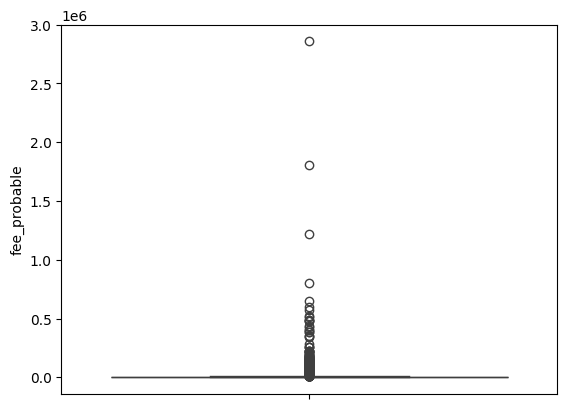

In [135]:
sns.boxplot(prop['fee_probable'])
#definitely some outliers here

In [136]:
threshold = prop['fee_probable'].quantile(0.995)
top_1_percent = prop[prop['fee_probable'] > threshold]
print(top_1_percent)
#These values look correct. They are consult/assessment project types for corporate accounts

       proposal_num registry_region                  rfp units_orig  \
1024  PCC-222615-00              Re                  NaN          -   
1367  PCC-224387-00              Re                  NaN          -   
1532  PCC-230125-00              Re                  NaN          -   
1594  PCC-230654-00              CA                  NaN          -   
1602  PCC-230486-00              TC                  NaN          -   
1642  PCC-230993-00              Ci           3447108958          -   
1653  PCC-231130-00              Fi      RFP - P-1077-22          -   
1655  PCC-230800-00              HS                  NaN          -   
2108  PCC-233766-00              Re            2023-051P          -   
2227  PCC-234384-00              Co                  NaN          -   
2286  PCC-240403-00              Yo                  NaN          -   
2390  PCC-241008-00              Re            2023-309P          -   
2526  PCC-241866-00              Ci  FIN-2023-03 P-31-23          -   
2748  

storeys

<Axes: ylabel='storeys'>

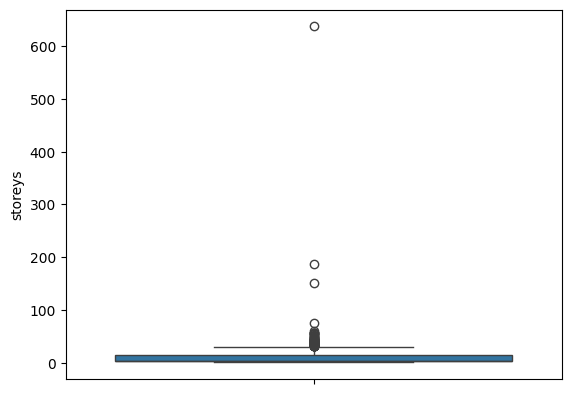

In [137]:
sns.boxplot(prop['storeys'])
#Highest value looks like it might be an error

In [138]:
print(prop[prop['storeys'] > 600])
#637 storeys looks to be an error based on the rest of the fields

    proposal_num registry_region  rfp  units_orig storeys_orig townhouse_orig  \
602      Q212767              TS  NaN  37 and 42           637              -   

    parking_orig prev_rfp reminder  fee_probable  ... outcome prev_wins  \
602            4      Yes       No        3995.0  ...    loss         0   

     townhouse_flag  storeys  comm_flag  comm_units  potl_units  res_units  \
602               0    637.0          0         NaN         NaN        NaN   

     building_age  project_type  
602          17.0           RFS  

[1 rows x 21 columns]


In [139]:
#Set storeys to 0 for index 5810
prop.loc[5810, 'storeys'] = 0

In [140]:
print(prop[prop['storeys'] > 600])

    proposal_num registry_region  rfp  units_orig storeys_orig townhouse_orig  \
602      Q212767              TS  NaN  37 and 42           637              -   

    parking_orig prev_rfp reminder  fee_probable  ... outcome prev_wins  \
602            4      Yes       No        3995.0  ...    loss       0.0   

     townhouse_flag  storeys  comm_flag  comm_units  potl_units  res_units  \
602             0.0    637.0        0.0         NaN         NaN        NaN   

     building_age  project_type  
602          17.0           RFS  

[1 rows x 21 columns]


comm_units

<Axes: ylabel='comm_units'>

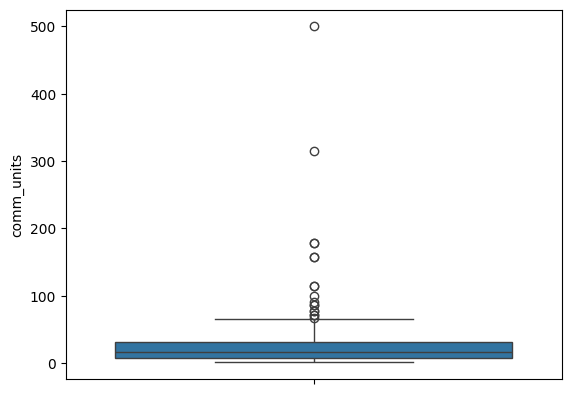

In [141]:
sns.boxplot(prop['comm_units'])
#The highest two values are suspicious

In [142]:
print(prop[prop['comm_units'] > 300])
#The 500 one is bc of my cleaning grabbing the wrong value fromthe word 'combine'. Will change it

       proposal_num registry_region  rfp                           units_orig  \
476         Q210864              YC  NaN                         315 Comm/Ind   
2003  PCC-233242-00              Se  NaN  326 (5Bldgs)\n372,500 combine sqft.   

                     storeys_orig townhouse_orig parking_orig prev_rfp  \
476                             9              -            -       No   
2003  5 elevators/bldg\n5 storeys              -            -       No   

     reminder  fee_probable  ... outcome prev_wins  townhouse_flag  storeys  \
476       Yes        5295.0  ...    loss       0.0             0.0      9.0   
2003       No       17500.0  ...    loss       0.0             0.0      5.0   

      comm_flag  comm_units  potl_units  res_units  building_age  project_type  
476         1.0       315.0         NaN        NaN          45.0           RFS  
2003        1.0       500.0         NaN        NaN          40.0    Assessment  

[2 rows x 21 columns]


In [143]:
prop.loc[12756, 'comm_units'] = 0
prop.loc[12756, 'comm_flag'] = np.nan

potl_units

<Axes: ylabel='potl_units'>

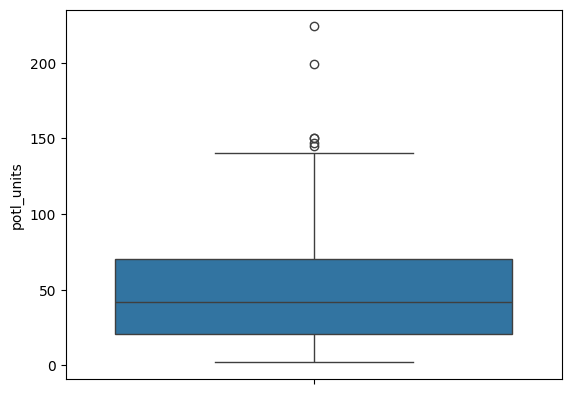

In [144]:
sns.boxplot(prop['potl_units'])
#This one looks pretty good. I'll check the two high values just in case

In [145]:
print(prop[prop['potl_units'] > 175])
#Confirmed I am grabbing the values correctly

       proposal_num registry_region  rfp  units_orig storeys_orig  \
475         Q210861              PC  NaN  199 POTL's            -   
2176  PCC-234291-00              TS  NaN  224 POTL's            -   

     townhouse_orig parking_orig prev_rfp reminder  fee_probable  ... outcome  \
475               -            -       No      Yes        3295.0  ...    loss   
2176              -            -      Yes       No        3595.0  ...     win   

     prev_wins  townhouse_flag  storeys  comm_flag  comm_units  potl_units  \
475        0.0             0.0      NaN        0.0         NaN       199.0   
2176       1.0             0.0      NaN        0.0         NaN       224.0   

      res_units  building_age  project_type  
475         NaN          12.0           RFS  
2176        NaN          11.0           RFS  

[2 rows x 21 columns]


res_units

<Axes: ylabel='res_units'>

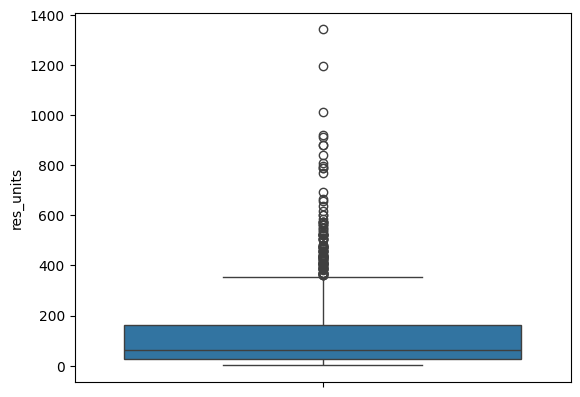

In [146]:
sns.boxplot(prop['res_units'])
#This isn't very surprising, but I'll check the highest ones to be sure

In [147]:
print(prop[prop['res_units'] > 1000])
#Given the storeys this looks correct

       proposal_num registry_region  rfp units_orig       storeys_orig  \
610         Q212795              TS  NaN       1012                 49   
1921  PCC-232807-00              TS  NaN       1343           57 &  67   
2560  PCC-242097-00              TS  NaN       1195  25 (3 buildiings)   

     townhouse_orig parking_orig prev_rfp reminder  fee_probable  ... outcome  \
610               -            4       No       No       41990.0  ...    loss   
1921              -            -       No       No       20395.0  ...    loss   
2560              -            -       No       No        2995.0  ...     win   

     prev_wins  townhouse_flag  storeys  comm_flag  comm_units  potl_units  \
610        0.0             0.0     49.0        0.0         NaN         NaN   
1921       0.0             0.0      NaN        0.0         NaN         NaN   
2560       0.0             0.0      NaN        0.0         NaN         NaN   

      res_units  building_age  project_type  
610      1012.0    

building_age

<Axes: ylabel='building_age'>

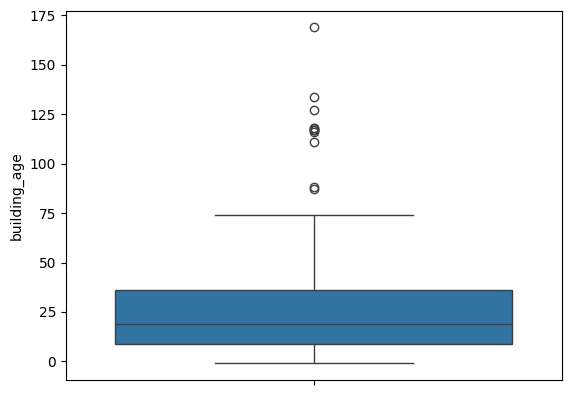

In [148]:
sns.boxplot(prop['building_age'])
#Nothing surprising here

In [149]:
print(prop[prop['building_age'] > 150])
#Confirmed this is correct

       proposal_num registry_region  rfp            units_orig  \
1347  PCC-224529-00              Fu  NaN  Court House and Jail   

                              storeys_orig townhouse_orig parking_orig  \
1347  2-storey front & 3storey back (jail)            NaN          NaN   

     prev_rfp reminder  fee_probable  ... outcome prev_wins  townhouse_flag  \
1347       No       No       40000.0  ...    loss       0.0             0.0   

      storeys  comm_flag  comm_units  potl_units  res_units  building_age  \
1347      3.0        0.0         NaN         NaN        NaN         169.0   

      project_type  
1347    Assessment  

[1 rows x 21 columns]
